In [4]:
import os
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val_test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './data'
full_dataset = datasets.ImageFolder(os.path.join(data_dir), data_transforms['train'])

train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

val_dataset.dataset.transform = data_transforms['val_test']
test_dataset.dataset.transform = data_transforms['val_test']

batch_size = 32
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4),
    'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
}

dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset),
    'test': len(test_dataset)
}

class_names = full_dataset.classes

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class ImprovedCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.batchnorm3 = nn.BatchNorm2d(256)
        self.batchnorm4 = nn.BatchNorm2d(512)
        
        self.fc1 = nn.Linear(512 * 14 * 14, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.batchnorm1(self.conv1(x))))
        x = self.pool(F.leaky_relu(self.batchnorm2(self.conv2(x))))
        x = self.pool(F.leaky_relu(self.batchnorm3(self.conv3(x))))
        x = self.pool(F.leaky_relu(self.batchnorm4(self.conv4(x))))
        
        x = x.view(-1, 512 * 14 * 14)
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

Epoch 1/30
----------
train Loss: 7.9043 Acc: 0.2779
val Loss: 1.5271 Acc: 0.4248
Epoch 2/30
----------
train Loss: 1.6632 Acc: 0.3412
val Loss: 1.4203 Acc: 0.4400
Epoch 3/30
----------
train Loss: 1.5925 Acc: 0.3617
val Loss: 1.3630 Acc: 0.4952
Epoch 4/30
----------
train Loss: 1.5410 Acc: 0.3945
val Loss: 1.2263 Acc: 0.5410
Epoch 5/30
----------
train Loss: 1.5197 Acc: 0.4079
val Loss: 1.2828 Acc: 0.5162
Epoch 6/30
----------
train Loss: 1.4573 Acc: 0.4412
val Loss: 1.2587 Acc: 0.5486
Epoch 7/30
----------
train Loss: 1.4194 Acc: 0.4545
val Loss: 1.1993 Acc: 0.5581
Epoch 8/30
----------
train Loss: 1.4227 Acc: 0.4540
val Loss: 1.2127 Acc: 0.5810
Epoch 9/30
----------
train Loss: 1.3785 Acc: 0.4790
val Loss: 1.2802 Acc: 0.5371
Epoch 10/30
----------
train Loss: 1.3656 Acc: 0.4776
val Loss: 1.1113 Acc: 0.5981
Epoch 11/30
----------
train Loss: 1.3622 Acc: 0.4790
val Loss: 1.1430 Acc: 0.5886
Epoch 12/30
----------
train Loss: 1.3489 Acc: 0.4857
val Loss: 1.1585 Acc: 0.6133
Epoch 13/30
-

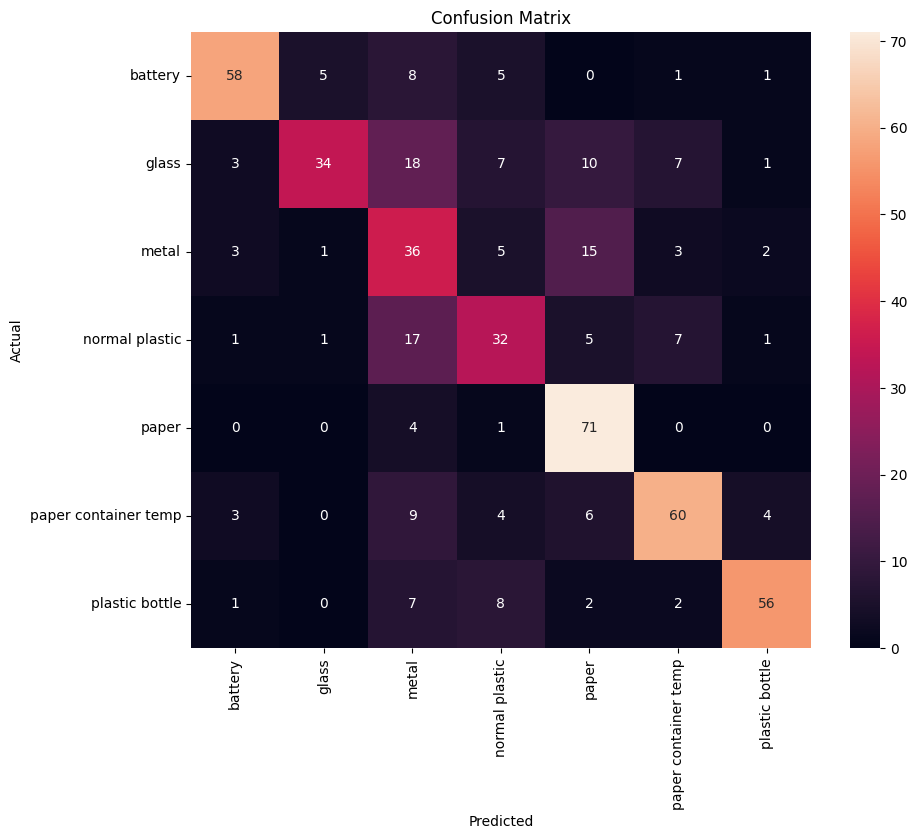

                      precision    recall  f1-score   support

             battery       0.84      0.74      0.79        78
               glass       0.83      0.42      0.56        80
               metal       0.36      0.55      0.44        65
      normal plastic       0.52      0.50      0.51        64
               paper       0.65      0.93      0.77        76
paper container temp       0.75      0.70      0.72        86
      plastic bottle       0.86      0.74      0.79        76

            accuracy                           0.66       525
           macro avg       0.69      0.66      0.65       525
        weighted avg       0.70      0.66      0.66       525



In [6]:
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


num_classes = len(class_names)
model = ImprovedCNN(num_classes=num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 30

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)
    
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

print('Training complete')

model.eval()
running_corrects = 0
all_labels = []
all_preds = []

for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

    running_corrects += torch.sum(preds == labels.data)
    all_labels.extend(labels.cpu().numpy())
    all_preds.extend(preds.cpu().numpy())

test_acc = running_corrects.double() / dataset_sizes['test']
print(f'Test Accuracy: {test_acc:.4f}')

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 分类报告
report = classification_report(all_labels, all_preds, target_names=class_names)
print(report)